In [1]:
!pip install fastf1
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.13.0 requires websockets<16.0.0,>=15.0.1, but you have websockets 13.1 which is incompatible.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 13.1 which is incompatible.


core           INFO 	Loading data for Italian Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Italian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core         

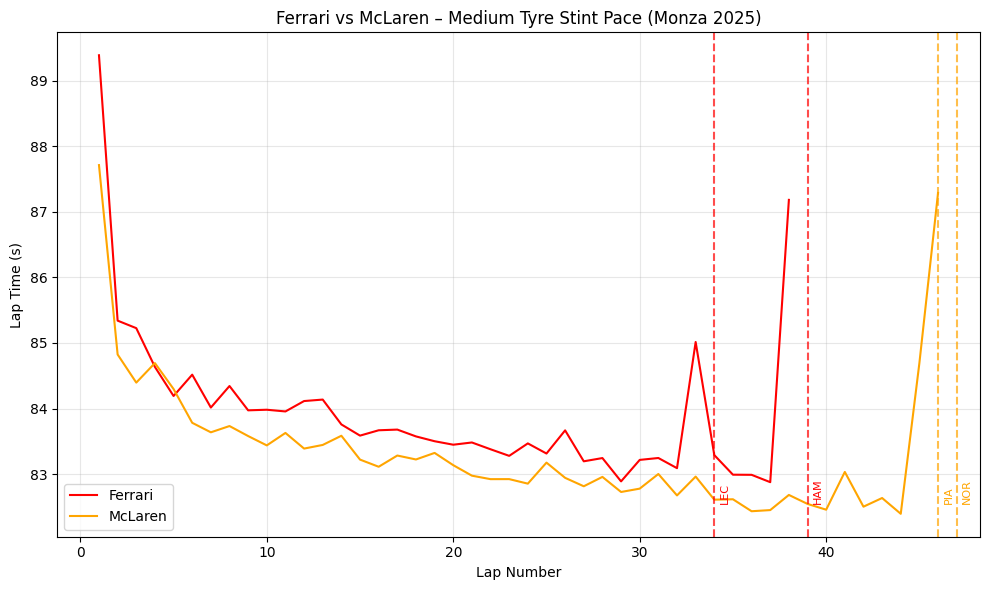

In [7]:
import fastf1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# -----------------------------
# Enable FastF1 cache (stores downloaded F1 data locally for faster reloads)
# -----------------------------
if not os.path.exists('cache'):
    os.makedirs('cache')
fastf1.Cache.enable_cache('cache')

# -----------------------------
# Load race session data
# -----------------------------
session = fastf1.get_session(2025, "Italian Grand Prix", "R")
session.load(laps=True)

# -----------------------------
# Define drivers and their teams (for grouping + colors later)
# -----------------------------
drivers = {
    "LEC": "Ferrari",
    "HAM": "Ferrari",   # 👀 Double-check: HAM should be Mercedes?
    "NOR": "McLaren",
    "PIA": "McLaren"
}

# -----------------------------
# Filter laps: only medium tyres + valid lap times + selected drivers
# -----------------------------
laps = session.laps
medium_stints = laps[
    (laps['Compound'] == 'MEDIUM') &
    (laps["LapTime"].notna()) &
    (laps["Driver"].isin(drivers.keys()))
]

# -----------------------------
# Calculate average lap times per driver per lap
# -----------------------------
avg_pace = medium_stints.groupby(["Driver", "LapNumber"])["LapTime"].mean().reset_index()
avg_pace["Team"] = avg_pace["Driver"].map(drivers)
avg_pace["LapTime_s"] = avg_pace["LapTime"].dt.total_seconds()

# -----------------------------
# Calculate team average pace per lap
# -----------------------------
team_avg = avg_pace.groupby(["Team", "LapNumber"])["LapTime_s"].mean().reset_index()

# -----------------------------
# Define pit stop laps manually (example data)
# -----------------------------
pit_laps = {
    "LEC": 34,
    "HAM": 39,
    "NOR": 47,
    "PIA": 46
}

# -----------------------------
# Team colors for plotting
# -----------------------------
team_colors = {
    "Ferrari": "red",
    "McLaren": "orange"
}

# -----------------------------
# Final Plot
# -----------------------------
plt.figure(figsize=(10,6))

# Plot average lap pace for each team
for team in team_avg["Team"].unique():
    df = team_avg[team_avg["Team"] == team]
    plt.plot(df["LapNumber"], df["LapTime_s"],
             label=team,
             color=team_colors[team])

# Add vertical lines for pit stops
for drv, lap in pit_laps.items():
    team = drivers[drv]
    plt.axvline(lap, linestyle="--", color=team_colors[team], alpha=0.7)
    plt.text(lap+0.3, plt.ylim()[0]+0.5, drv,
             rotation=90, va="bottom", ha="left",
             color=team_colors[team], fontsize=8)

# Labels & formatting
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (s)")
plt.title("Ferrari vs McLaren – Medium Tyre Stint Pace (Monza 2025)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
